In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import librosa
import librosa.display
import IPython.display
from skimage.transform import resize

from src.data import NSynthDataset
from src.models import Autoencoder, SpatialTimeAutoencoder

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
model = Autoencoder(h_dim=1024)
model.load_state_dict(torch.load('train_results/autoencoder/20200604-225843/model-9000.weights'))
model.eval()

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(512, 512, kernel_size=(4, 4)

In [4]:
loss_fn = nn.BCELoss()

##### Real instrument

In [6]:
val_dataset = NSynthDataset(
    'data/nsynth/nsynth-valid', 
    instrument_source=[0], 
    feature_type='mel',
    scaling='normalize',
    resize=(128, 128)
)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
features = val_dataset[0]

In [8]:
with torch.no_grad():
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    outputs = model(features)

    print(loss_fn(outputs, features).item())

0.001992293866351247


##### Noise

In [9]:
features = torch.tensor(np.random.rand(1, 1, 128, 128), dtype=torch.float32)
features = (features - features.min()) / (features.max() - features.min())

In [10]:
with torch.no_grad():
    outputs = model(features)

    print(loss_fn(outputs, features).item())

6.087832450866699


##### Sample

In [35]:
def highpass_filter(x, sr, freq):
    filter_stop_freq = freq-50  # Hz
    filter_pass_freq = freq  # Hz
    filter_order = 1001

    # High-pass filter
    nyquist_rate = sr / 2.
    desired = (0, 0, 1, 1)
    bands = (0, filter_stop_freq, filter_pass_freq, nyquist_rate)
    filter_coefs = scipy.signal.firls(filter_order, bands, desired, nyq=nyquist_rate)

    # Apply high-pass filter
    filtered_audio = scipy.signal.filtfilt(filter_coefs, [1], x)
    return filtered_audio

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

In [40]:
sample_file = 'samples/180156__klankbeeld__traffic-horns-city-nervous-busy.wav'
#sample_file = 'samples/269570__vonora__cuckoo-the-nightingale-duet.wav'
#sample_file = 'samples/504900__soundmast123__restaurant-ambience.wav'
#sample_file = 'samples/389684__meggiepie__pots-and-pans.wav'

In [41]:
x, sr = librosa.load(sample_file, sr=16000)
#x = highpass_filter(x, sr, 100)

In [42]:
IPython.display.Audio(x, rate=16000)

In [73]:
# noise = x[:sr]

In [74]:
# IPython.display.Audio(noise, rate=16000)

In [36]:
# denoised = removeNoise(x, noise)

[ 30.549679  28.115688  26.104115 ... -39.721687 -39.71457  -39.70481 ] -40.460762


In [39]:
# IPython.display.Audio(denoised, rate=16000)

In [41]:
# x = denoised

In [43]:
class Sample:
    def __init__(self, sample, sr, pad_len, n_fft=1024, hop_length=256, resize_shape=(128, 128)):
        self.sample = sample
        self.sr = sr
        self.pad_len = pad_len
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.resize_shape = resize_shape
        
        self.mel = self._extract_mel()
        self.real_mel_len = int(self.mel.shape[1] * (len(self.sample) / self.pad_len))
        
        
        self.embedding = None
        self.reconstruction = None
        self.score = None
        
    def _extract_mel(self):
        pad = np.zeros(self.pad_len - len(self.sample), dtype=self.sample.dtype)
        sample_padded = np.concatenate([self.sample, pad])
        
        mel = librosa.feature.melspectrogram(y=sample_padded, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length)
        mel = resize(mel, self.resize_shape)
        mel = (mel - mel.min()) / (mel.max() - mel.min())
        return mel

##### 0.25 - 4 second segments

In [44]:
max_window_len = 4*sr
window_scales = [1/16, 1/8, 1/4, 1/2, 1]
step_size = int(sr/2)

samples = []
for i in range(int(len(x)/step_size - int(max_window_len/step_size) + 1)):
    for n, scale in enumerate(window_scales):
        frame = x[i*step_size:i*step_size+int(max_window_len*scale)]
        s = Sample(frame, sr, max_window_len, n_fft=1024, hop_length=256, resize_shape=(128, 128))
        samples.append(s)

In [45]:
def mask_tensor(tensor, lens, max_len):
    mask = torch.arange(max_len).expand(len(lens), max_len) < lens.unsqueeze(1)
    mask = mask.unsqueeze(1).unsqueeze(1).expand(tensor.size()).to(torch.float32)
    return tensor*mask

In [46]:
batch_size = 32
max_mel_length = max([x.mel.shape[-1] for x in samples])

loss_fn = nn.BCELoss(reduction='none')
loss_weighting = lambda x : 1 #99*(x**2)+1

In [47]:
with torch.no_grad():
    for i in range(int(np.ceil(len(samples)/batch_size))):
        batch = samples[i*batch_size:(i+1)*batch_size]
        lens = torch.tensor([x.real_mel_len for x in batch], dtype=torch.int32)
        features = torch.stack([torch.tensor(x.mel, dtype=torch.float32) for x in batch]).unsqueeze(1)

        outputs = model(features)
        embds = model.encode(features)
        loss = loss_fn(outputs, features)
        loss = loss_weighting(features)*loss
        loss = mask_tensor(loss, lens, max_mel_length)
        loss = loss.squeeze(1).mean(1).sum(1)/lens

        reconstructions = outputs.detach().numpy().squeeze(1)
        embeddings = embds.detach().numpy().squeeze(2).squeeze(2)
        scores = loss.detach().numpy()

        for samp, rec, emb, scr in zip(batch, reconstructions, embeddings, scores):
            samp.reconstruction = rec
            samp.embedding = emb
            samp.score = scr

In [48]:
sorted_samples = sorted(samples, key=lambda x : x.score)

### Original Source

In [49]:
IPython.display.Audio(x, rate=16000)

### Good Scores

In [50]:
IPython.display.Audio(sorted_samples[0].sample, rate=16000)

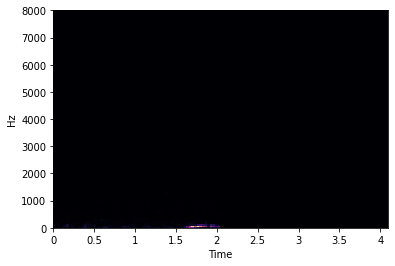

In [51]:
librosa.display.specshow(sorted_samples[0].mel, sr=16000, x_axis='time', y_axis='hz')

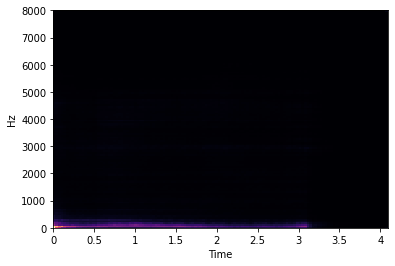

In [52]:
librosa.display.specshow(sorted_samples[0].reconstruction, sr=16000, x_axis='time', y_axis='hz')

In [53]:
IPython.display.Audio(sorted_samples[1].sample, rate=16000)

In [54]:
IPython.display.Audio(sorted_samples[2].sample, rate=16000)

In [55]:
IPython.display.Audio(sorted_samples[3].sample, rate=16000)

In [56]:
IPython.display.Audio(sorted_samples[4].sample, rate=16000)

In [57]:
IPython.display.Audio(sorted_samples[5].sample, rate=16000)

### Bad Scores

In [58]:
IPython.display.Audio(sorted_samples[-1].sample, rate=16000)

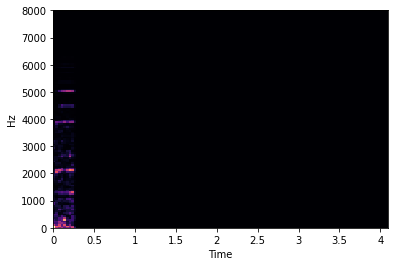

In [59]:
librosa.display.specshow(sorted_samples[-1].mel, sr=16000, x_axis='time', y_axis='hz')

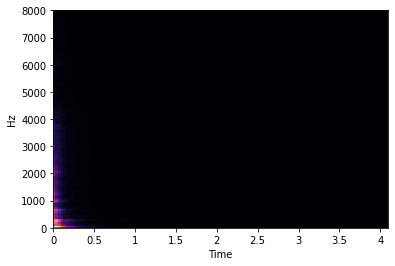

In [60]:
librosa.display.specshow(sorted_samples[-1].reconstruction, sr=16000, x_axis='time', y_axis='hz')

In [61]:
IPython.display.Audio(sorted_samples[-2].sample, rate=16000)

In [62]:
IPython.display.Audio(sorted_samples[-3].sample, rate=16000)

In [63]:
IPython.display.Audio(sorted_samples[-4].sample, rate=16000)

In [64]:
IPython.display.Audio(sorted_samples[-5].sample, rate=16000)

### Clustering

In [150]:
from sklearn.cluster import KMeans
from collections import Counter

In [151]:
kmeans = KMeans(n_clusters=5)

In [152]:
clusters = kmeans.fit_predict([x.embedding for x in sorted_samples])

In [153]:
Counter(clusters)

Counter({0: 28, 1: 42, 3: 64, 4: 40, 2: 36})

In [154]:
clustered_samples = sorted(list(zip(sorted_samples, clusters)), key=lambda x : x[1])

In [155]:
clustered_samples[0]

(<__main__.Sample at 0x7f48c43a7518>, 0)

In [172]:
s = clustered_samples[130]
print(s[1])
IPython.display.Audio(s[0].sample, rate=16000)

3


In [176]:
s = clustered_samples[142]
print(s[1])
IPython.display.Audio(s[0].sample, rate=16000)

3


In [174]:
s = clustered_samples[120]
print(s[1])
IPython.display.Audio(s[0].sample, rate=16000)

3
